<h1 id="tocheading">Finding Patterns in Data using IBM Power and PowerAI</h1>
<div id="toc"></div>

In this lab we will explore an open source data set, and discover how we can use the tools that are part of **PowerAI** to explore and discover patterns in the data.  For this lab, we will make use of the Lending Club data set, pandas, numpy and scikit learn libraries.  Here is a brief description about Lending Club.



<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-banner.png" width="800" height="500" align="middle"/>

[Lending Club (LC)](https://www.lendingclub.com/) is the world’s largest online marketplace connecting borrowers and investors. It is transforming the banking system to make credit more affordable and investing more rewarding. Lending Club operates at a lower cost than traditional bank lending programs and pass the savings on to borrowers in the form of lower rates and to investors in the form of solid risk-adjusted returns.

**The DATA**  
The original data set is downloaded from [LC](https://www.lendingclub.com/info/download-data.action) covering complete loan data for all loans issued through the 2007-2018, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. Additional features include credit history, number of finance inquiries, address including zip codes, and state, and collections among others. It is quite rich and is an excellent example of credit risk data.  Interestingly, Goldman Sachs’ new peer-to-peer lending platform called Marcus was built almost entirely using the Lending Club data.

Here is a link to some extra information regarding the fields of the data set.
[Data Dictionary](https://github.com/dustinvanstee/mldl-101/blob/master/lab5-powerai-lc/LCDataDictionary.csv)

**Important**

In this notebook, we will play with the lending club data, conduct a set of exploratory analysis and try to apply various machine learning techniques to predict borrower’s default. We took a small sample of loans made in 2016 (130K) to help speed up the processing time for the lab


Note : to remove a lot of the busy verbose code, we are making using of a utility python file called lc_utils.py.  For implemenation details you can refer here [python code](https://github.com/dustinvanstee/mldl-101/blob/master/lab5-powerai-lc/lc_utils.py)

### Quick word on the data science method
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/dsx-methodology.png" width="900" height="700" align="middle"/>

Here we will use these simple high level steps to work through a typical data science problem.  This workflow is meant to be a high level guide, but in practice this is a highly iterative approach ...

### Goals

* Perform some initial analysis of the data for **Business Understanding**
* **Prepare the Data** for our visualization and modeling
* **Visualize** the data
* Model using **Dimension Reduction** and **Classification** techniques
* **Evaluate** the approach

## Business/Data Understanding and Preparation
<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-bu-dp.png" width="800" height="500" align="middle"/>

### Import Libraries

In [1]:
# Code functions that are needed to run this lab
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime
import math

import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob

# custom library for some helper functions 
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import myenv as myenv
from lc_utils_2020 import *


In [2]:
%load_ext autoreload
%autoreload 2
from lc_utils_2020 import *

### Load the Data
Here we load data that was previously downloaded from lendingclub.com.  For speed of this lab, we are restricting the number of loans ~ 130K

**Key functions**
* pd.read_csv
* pd.concat

In [35]:
loan_df = load_sample_data('acc')
loan_df_orig = loan_df.copy()
loan_df.head(30)

**load_sample_data** : Setting data location to /gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/
**load_sample_data** : Found 1 files.  CSV files = ['/gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q1.csv.gz']
**load_sample_data** : Loading /gpfs/home/s4s004/vanstee/2019-06-lendingclub-git/rawdata/LoanStats_securev1_2016Q1.csv.gz


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,16098.340000,16098.34,16000.00,98.34,0.00,0.00,0.000,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,16630.580000,16630.58,15143.02,1487.56,0.00,0.00,0.000,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0

### Descriptive Statistics (1D)
Lets look at some 1D and 2D descriptive statistics for this dataset

In this dataset, we have all types of data.  Numerical, Categorical, Ranked data.  This small module will take you through what is typical done to quickly understand the data


**Key Functions**
* df[column].value_counts()
* df.describe()

In [44]:
# This function provide the number of rows/cols
# Information on the types of data
# and a report of descriptive statistics

# quick_overview_1d(loan_df)
categorical_overview,numerical_overview = quick_overview_1d_v2(loan_df)
print("Categorical report")
display(categorical_overview)
print("Numerical report")
display(numerical_overview)

**quick_overview_1d_v2** : There are 133889 observations in the dataset.
**quick_overview_1d_v2** : There are 151 variables in the dataset.
**quick_overview_1d_v2** : 


**quick_overview_1d_v2** : 
****************** Histogram of data types  *****************************

**quick_overview_1d_v2** : use df.dtypes ...
float64    112
object      39
Name: dtype, dtype: int64
**quick_overview_1d_v2** : 


**quick_overview_1d_v2** : 
****************** Generating Cardinality Report (all types) *****************************

**quick_overview_1d_v2** : 
****************** Generating NaNs Report *****************************

**quick_overview_1d_v2** : 
******************Generating Descriptive Statistics (numerical columns only) *****************************

Categorical report


,id,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
dtype,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
cardinality,133889,2,90,7,35,46274,11,3,3,3,7,2,133887,7,12,13,891,50,633,1119,2,23,3,24,2,1,2,1,9,3,11,12,11,4,2,2,17,3,18
nan_count,0,2,2,2,2,8983,8946,2,2,2,2,2,2,133879,2,10623,2,2,2,73,2,150,48695,4,2,131228,2,133115,133115,133115,133115,133115,133115,133115,2,2,132802,132802,132802
pct_missing,0,0.00149377,0.00149377,0.00149377,0.00149377,6.70929,6.68165,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,99.9925,0.00149377,7.93418,0.00149377,0.00149377,0.00149377,0.0545228,0.00149377,0.112033,36.3697,0.00298755,0.00149377,98.0125,0.00149377,99.4219,99.4219,99.4219,99.4219,99.4219,99.4219,99.4219,0.00149377,0.00149377,99.1881,99.1881,99.1881


Numerical report


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,0,1397,1397,1419,20812,11324,4966,23,38,38,6,125,122,61,20,43750,115,42007,43637,99066,99560,54105,93252,1739,5244,5321,54139,72,71,10,160,1,940,1701,4,4706,105463,17,42,17,24,272,65691,198,25,40,21320,156,6162,25,48,37,44,39120,34753,1188,8,522,442,666,198,145,25,357,125,26,129,32,31,43,43,51,92,55,84,40,60,3,4,20,27,472,162,9,20,102434,79079,3551,68480,0,0,0,0,0,0,0,0,0,0,0,0,0,1,751,1,30,619,774,718,1071,143,28
nan_count,133889,2,2,2,2,2,19,2,2,2,3,64567,110218,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,95815,2,131228,131230,2,2,2,64,63,63,63,3703,63,17881,63,63,63,69,2,63,64,64,2,2,1113,1177,2,2,3648,2,2,2,2,1046,100133,13800,86106,2,2,2,2,2,2,2,2,2,2,7623,2,2,2,2,1131,2,2,2,2,2,2,133889,133889,133889,133889,133889,133889,133889,133889,133889,133889,133889,133889,133889,133115,133115,133115,133115,133254,133115,133115,132802,132802,132802
pct_missing,100,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.0141909,0.00149377,0.00149377,0.00149377,0.00224066,48.2243,82.3204,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,0.00149377,71.563,0.00149377,98.0125,98.014

Here we can get a quick assessment of the statistics for each column.  
**Quick Question** can you answer what was the average income for the 133K loan applicants ?

### Descriptive Statistics (2D)
Since we have over 100 numerical variables, creating a 2D correlation plot may be time consuming and difficult to interpret.  Lets look at correlations on a smaller scale for now....


**quick_overview_2d** : There are 133889 observations in the dataset.
**quick_overview_2d** : There are 151 variables in the dataset.


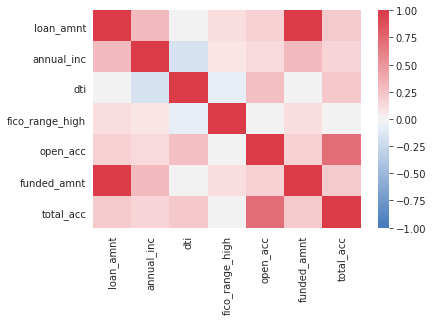

In [45]:
# Grab only a subset of columns
cols = ["loan_amnt","annual_inc","dti","fico_range_high","open_acc",'funded_amnt', 'total_acc']
quick_overview_2d(loan_df, cols)

**Quick Question** : Can you find a negatively correlated variable to annual_inc in the chart above?  Can you think of a reason for this result ?

### Create Loan Default column.  This is the column we will predict later
The **loan_status** column contains the information of whether or not the loan is in default. 

This column has more than just a 'default or paid' status.  Since our goal is to build a simple default classifier , we need to make a new column based off the **loan_status** column.

Here we will look at all the categorical values in **loan_status**, and create a new column called **default** based off that one.


In [46]:
# function to create loan status .... 
loan_df = create_loan_default(loan_df)
loan_df.head(3) # scroll to the right, and see the new 'default' column

**create_loan_default** : Dropping other values that are highly correlated with loan_status
**create_loan_default** : Dropping loan_status,total_rec_prncp,total_pymnt,total_pymnt_inv
**create_loan_default** : Unique values in default
0    117220
1     16669
Name: default, dtype: int64


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,default
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939.0,16300.0,27831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Data Preparation - Handle Null Values aka NaNs ...

One part of the data science process thats especially time consuming is working with unclean data.  This lending club data set is a great example of that.  If you look at the dataframe shown above, you will see a number of columns with the indicator **NaN** .  This means 'not a number' and needs to be dealt with prior to any machine learning steps.  You have many options here.  Some options are listed below...

* Fill with a value -> impute mean/median/min/max/other
* drop rows with NaNs
* drop columns with large number of NaNs 
* use data in other columns to derive

All these methods are possible, but its up to the data scientist / domain expert to figure out the best approach.  There is definitely some grey area involved in whats the best approach.

First, lets understand which columns have NaNs...

In [47]:
# For every column, count the number of NaNs .... 
# code hint : uses df.isna().sum()

columns_with_nans(loan_df)

,column_name,nan_count,pct_missing
0,id,0,0.000000
1,member_id,133889,1.000000
2,loan_amnt,2,0.000015
3,funded_amnt,2,0.000015
4,funded_amnt_inv,2,0.000015
5,term,2,0.000015
6,int_rate,2,0.000015
7,installment,2,0.000015
8,grade,2,0.000015
9,sub_grade,2,0.000015



As you can see, we have some work to do to clean up the NaN values.  Beyond NaN values, we also have to transform columns if they aren't formatted correctly, or maybe we want to transform a column based on custom requirements.  

```
Example : column=employee_length , values=[1,2,3,4,5,6,7,8,9,10+] formatted as a string
          transform into 
          column=employee_length, [0_3yrs,4_6yrs,gt_6yrs] (categorical:strings)
```
          
Luckily, we took care to process and clean this data below using a few functions.  In practice, **this is where data scientists spend a large portion of their time** as this requires detailed domain knowledge to clean the data.  We have made a fair number of assumptions about how to process the data which we won't go into due to time contraints for the lab.

In [8]:
# The following cleaning of the data makes use of the steps shown below.....

# loan_df1 = drop_sparse_numeric_columns(loan_df, threshold=0.03)
loan_df1 = drop_sparse_columns(loan_df,pct_missing_threshold=0.6)
loan_df2 = impute_columns(loan_df1)
loan_df3 = handle_employee_length(loan_df2)
loan_df4 = handle_revol_util(loan_df3)
loan_df = loan_df4
columns_with_nans(loan_df4)


**drop_sparse_columns** : Dropping columns with greater than 0.6 pct cells that are null
dropping column member_id bc it has 1.0 of nulls
dropping column desc bc it has 0.9999253112653018 of nulls
dropping column mths_since_last_record bc it has 0.8232042960960199 of nulls
dropping column mths_since_last_major_derog bc it has 0.7156301115102809 of nulls
dropping column annual_inc_joint bc it has 0.9801253276968235 of nulls
dropping column dti_joint bc it has 0.9801402654437631 of nulls
dropping column verification_status_joint bc it has 0.9801253276968235 of nulls
dropping column mths_since_recent_bc_dlq bc it has 0.7478807071529401 of nulls
dropping column mths_since_recent_revol_delinq bc it has 0.6431148189918514 of nulls
dropping column revol_bal_joint bc it has 1.0 of nulls
dropping column sec_app_fico_range_low bc it has 1.0 of nulls
dropping column sec_app_fico_range_high bc it has 1.0 of nulls
dropping column sec_app_earliest_cr_line bc it has 1.0 of nulls
dropping column sec_a

**impute_columns** : Filling 0 values of id with unknown
**impute_columns** : Filling 2 values of term with unknown
**impute_columns** : Filling 2 values of int_rate with unknown
**impute_columns** : Filling 2 values of grade with unknown
**impute_columns** : Filling 2 values of sub_grade with unknown
**impute_columns** : Filling 8983 values of emp_title with unknown
**impute_columns** : Filling 8946 values of emp_length with unknown
**impute_columns** : Filling 2 values of home_ownership with unknown
**impute_columns** : Filling 2 values of verification_status with unknown
**impute_columns** : Filling 2 values of issue_d with unknown
**impute_columns** : Filling 2 values of pymnt_plan with unknown
**impute_columns** : Filling 2 values of url with unknown
**impute_columns** : Filling 2 values of purpose with unknown
**impute_columns** : Filling 10623 values of title with unknown
**impute_columns** : Filling 2 values of zip_code with unknown
**impute_columns** : Filling 2 values of addr

,column_name,nan_count,pct_missing
0,id,0,0.0
1,loan_amnt,0,0.0
2,funded_amnt,0,0.0
3,funded_amnt_inv,0,0.0
4,term,0,0.0
5,int_rate,0,0.0
6,installment,0,0.0
7,grade,0,0.0
8,sub_grade,0,0.0
9,emp_title,0,0.0


In [10]:
# Final Sanity check ....
# If we did our job right, there should not be any NaN's left.  
# Use this convenience function to check

# code hint df.isna().sum()

columns_with_nans(loan_df)

,column_name,nan_count,pct_missing
0,id,0,0.0
1,loan_amnt,0,0.0
2,funded_amnt,0,0.0
3,funded_amnt_inv,0,0.0
4,term,0,0.0
5,int_rate,0,0.0
6,installment,0,0.0
7,grade,0,0.0
8,sub_grade,0,0.0
9,emp_title,0,0.0


### Data Preparation - Handle Time Objects
Sometimes for columns that contain date information, you may want to break them down into individual columns like month, day, day of week etc.  For our use case, we will create a new column called `time_history` that will indicate how long an applicant has been a borrower.  This is an example of **feature engineering**.  Essentially, using business logic to create a new column (feature) that may have predictive value.

In [48]:
#loan_df[loan_df["earliest_cr_line"]!="unknown"]

In [11]:
loan_df = create_time_features(loan_df)
loan_df.head(3)

**create_time_features** : Creating new column called time_history : Calculated feature showing how long applicant has been a borrower..


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,default,emp_bin,revol_util_1,time_history
0,76003542,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,RENT,105000.0,Not Verified,2016-03-01,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.00000,9.0,0.0,6219.0,21.0,w,0.00,0.00,98.34,0.00,0.0,0.0,May-2016,16107.80,unknown,Nov-2016,679.0,675.0,0.0,1.0,Individual,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,8.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,N,Cash,N,0,8.0,27.9,5599
1,76023477,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,MORTGAGE,40000.0,Verified,2016-03-01,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,2006-08-01,705.0,709.0,0.0,33.80781,4.0,0.0,14009.0,8.0,w,1856.98,1856.98,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,1.0,Individual,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,6.0,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939.0,16300.0,27831.0,N,Cash,N,0,0.0,85.9,3500
2,75993535,15000.0,15000.0,15000.0,60 months,15.31%,359.30,C,C5,Branch Manager,MORTGAGE,70000.0,Source Verified,2016-03-01,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Home improvement,750xx,TX,9.99,0.0,2002-01-01,690.0,694.0,0.0,32.00000,6.0,0.0,11630.0,22.0,w,0.00,0.00,2137.08,17.97,0.0,0.0,Apr-2017,13106.47,unknown,Mar-2017,754.0,750.0,0.0,1.0,Individual,0.0,0.0,27322.0,0.0,1.0,1.0,1.0,12.0,15692.0,72.0,1.0,2.0,5840.0,60.0,24000.0,3.0,0.0,6.0,3.0,4554.0,9808.0,38.7,0.0,0.0,160.0,152.0,9.0,9.0,3.0,9.0,8.0,0.0,2.0,4.0,3.0,6.0,7.0,5.0,12.0,4.0,6.0,0.0,0.0,0.0,2.0,95.5,33.3,0.0,0.0,45706.0,27322.0,16000.0,21706.0,N,Cash,N,0,10.0,48.5,5173


### Convert Categorical Data to One hot encode ###

If you look above at the data frame, we are almost ready to start building models.  However, there is one important step to complete.  Notice we have some columns that are still built out of string data 
```
example column=home_ownership values=[RENT, MORTGAGE, OWN]
```
Machine learning algorithms only process numerical data, so we need to transform these **categorical columns** into **indicator columns**

From the example above, the transform would yield 3 new columns

```
example column=RENT values=[0,1]
        column=MORTGAGE values=[0,1]
        column=OWN values=[0,1]
```

Conveniently pandas has a nice function called **get_dummies** that we will use for this purpose

In [12]:
# Transform categorical data into binary indicator columns
# code hint, uses pd.get_dummies

loan_df = one_hot_encode_keep_cols(loan_df)
loan_df.head() # once complete, see how many new columns you have!

**one_hot_encode_keep_cols** : Dropping these columns since they are greater than cardinality limit of 50
**one_hot_encode_keep_cols** : ['id', 'int_rate', 'emp_title', 'url', 'zip_code', 'addr_state']
**one_hot_encode_keep_cols** : Keeping these cols
**one_hot_encode_keep_cols** : ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'title', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,emp_bin,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Business,Car financing,Credit Card Consolidation,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation,unknown,f,w,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Dec-2017,Jan-2018,Nov-2017,unknown,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2015,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Individual,Joint App,N,Y,Cash,DirectPay,N,Y,id
0,16000.0,16000.0,16000.0,481.84,105000.0,2016-03-01,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.00000,9.0,0.0,6219.0,21.0,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,8.000000,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,0,8.0,27.9,5599,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,2016-03-01,24.30,0.0,2006-08-01,705.0,709.0,0.0,33.80781,4.0,0.0,14009.0,8.0,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,6.000000,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939.0,16300.0,27831.0,0,0.0,85.9,3500,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,2016-03-01,9.99,0.0,2002-01-01,690.0,694.0,0.0,32.00000,6.0,0.0,11630.0,22.0,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,0.0,0.0,27322.0,

### Final Result after data preparation ....

Ok, so you made it here, lets take a look at the final results of your data preparation work.  It may be helpful to  **qualitatively compare** your original data frame to this one and see how different they look..  Execute the cells below to get a sense of what the tranformations accomplished.

In [13]:
loan_df_orig.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,76003542,NaN,16000.0,16000.0,16000.0,36 months,5.32%,481.84,A,A1,Security specialist,8 years,RENT,105000.0,Not Verified,Mar-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,206xx,MD,15.02,1.0,Nov-2000,720.0,724.0,0.0,9.0,NaN,9.0,0.0,6219.0,27.9%,21.0,w,0.00,0.00,16098.340000,16098.34,16000.00,98.34,0.00,0.0,0.0,May-2016,16107.80,NaN,Nov-2016,679.0,675.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,NaN,8.0,9.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,76023477,NaN,17000.0,17000.0,17000.0,36 months,9.75%,546.55,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,Verified,Mar-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,440xx,NC,24.30,0.0,Aug-2006,705.0,709.0,0.0,NaN,NaN,4.0,0.0,14009.0,85.9%,8.0,w,1856.98,1856.98,16630.580000,16630.58,15143.02,1487.56,0.00,0.0,0.0,Nov-2017,546.55,Dec-2017,Nov-2017,799.0,795.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,NaN,6.0,NaN,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939

In [14]:
loan_df.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,emp_bin,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Business,Car financing,Credit Card Consolidation,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation,unknown,f,w,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Dec-2017,Jan-2018,Nov-2017,unknown,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2015,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Individual,Joint App,N,Y,Cash,DirectPay,N,Y,id
0,16000.0,16000.0,16000.0,481.84,105000.0,2016-03-01,15.02,1.0,2000-11-01,720.0,724.0,0.0,9.00000,9.0,0.0,6219.0,21.0,0.00,0.00,98.34,0.00,0.0,0.0,16107.80,679.0,675.0,0.0,1.0,0.0,0.0,23525.0,0.0,3.0,2.0,2.0,8.0,17306.0,69.0,0.0,1.0,3770.0,50.0,22300.0,1.0,3.0,1.0,3.0,3361.0,13632.0,29.7,0.0,0.0,124.0,184.0,22.0,8.0,0.0,52.0,8.0,0.0,2.0,3.0,2.0,5.0,7.0,6.0,14.0,3.0,9.0,0.0,0.0,0.0,2.0,95.2,0.0,0.0,0.0,47543.0,23525.0,19400.0,25243.0,0,8.0,27.9,5599,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,76003542
1,17000.0,17000.0,17000.0,546.55,40000.0,2016-03-01,24.30,0.0,2006-08-01,705.0,709.0,0.0,33.80781,4.0,0.0,14009.0,8.0,1856.98,1856.98,1487.56,0.00,0.0,0.0,546.55,799.0,795.0,0.0,1.0,0.0,0.0,31939.0,0.0,1.0,0.0,0.0,25.0,17930.0,64.0,0.0,0.0,4913.0,72.0,16300.0,1.0,0.0,1.0,0.0,7985.0,2291.0,85.9,0.0,0.0,25.0,115.0,35.0,25.0,0.0,35.0,6.0,0.0,3.0,3.0,3.0,5.0,1.0,3.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,44131.0,31939.0,16300.0,27831.0,0,0.0,85.9,3500,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,76023477
2,15000.0,15000.0,15000.0,359.30,70000.0,2016-03-01,9.99,0.0,2002-01-01,690.0,694.0,0.0,32.00000,6.0,0.0,11630.0,22.0,0.00,0.00,2137.08,17.97,0.0,0.0,13106.47,754.0,750.0,0.0,1.0,0.0,0.0,27322.0,0.0,1.0,1.

### Data Visualization
As you saw, when you 'describe' a data frame, you get a table statistics showing you the mean,min,max and other statistics about each column.  This is good, but sometimes its also good to look at the histograms of the data as well.  Lets Visualize some of the distributions from our dataset


<img src="https://github.com/dustinvanstee/random-public-files/raw/master/data-visualization.png" width="800" height="500" align="middle"/>

skipping column id of type  object
skipping column term of type  object
skipping column int_rate of type  object
skipping column grade of type  object
skipping column sub_grade of type  object
skipping column emp_title of type  object
skipping column emp_length of type  object
skipping column home_ownership of type  object
skipping column verification_status of type  object
skipping column issue_d of type  object
skipping column loan_status of type  object
skipping column pymnt_plan of type  object
skipping column url of type  object
skipping column desc of type  object
skipping column purpose of type  object
skipping column title of type  object
skipping column zip_code of type  object
skipping column addr_state of type  object
skipping column earliest_cr_line of type  object
skipping column revol_util of type  object
skipping column initial_list_status of type  object
skipping column last_pymnt_d of type  object
skipping column next_pymnt_d of type  object
skipping column last_credit

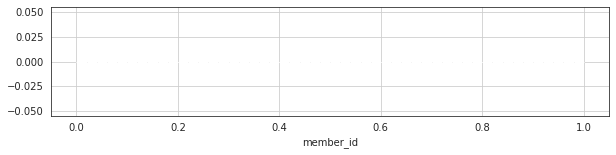

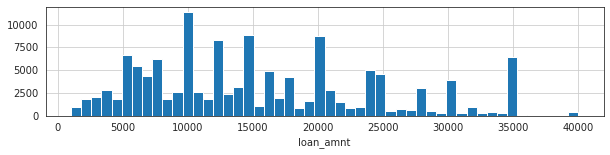

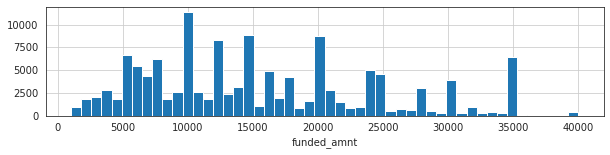

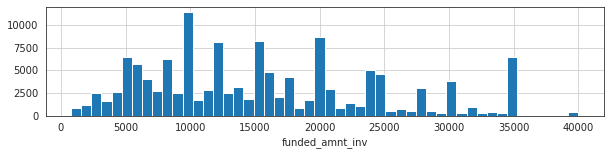

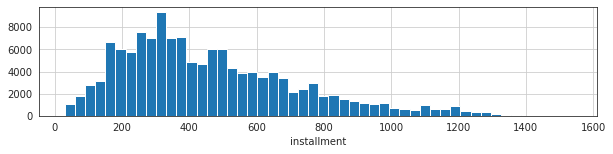

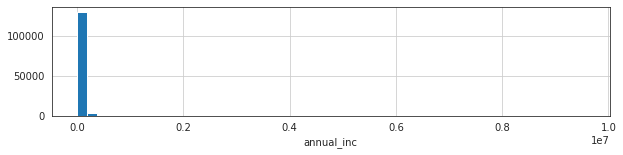

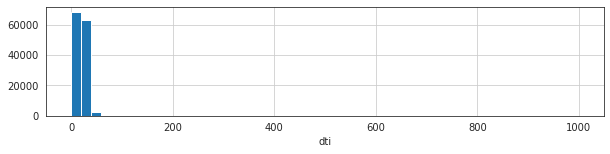

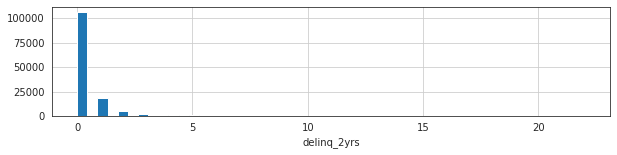

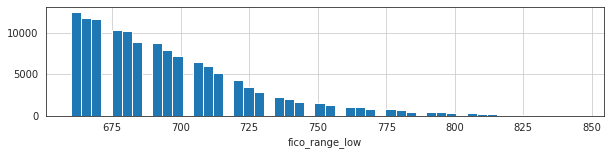

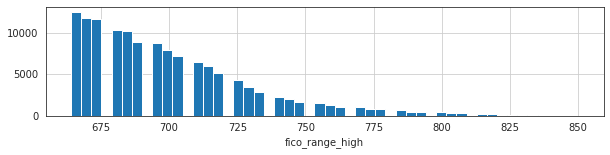

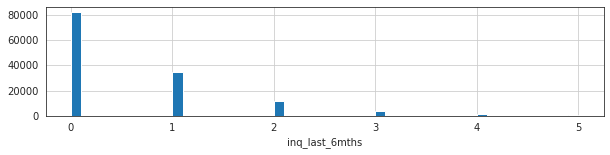

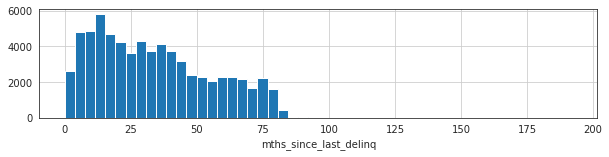

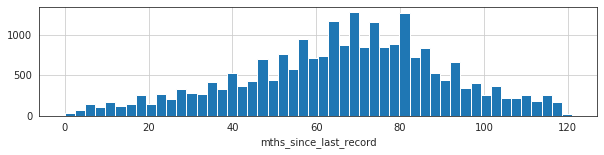

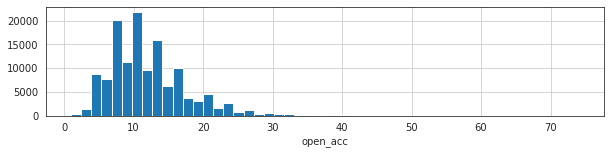

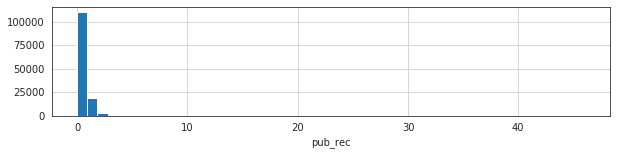

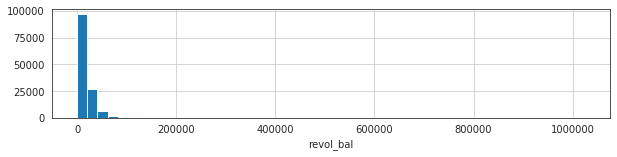

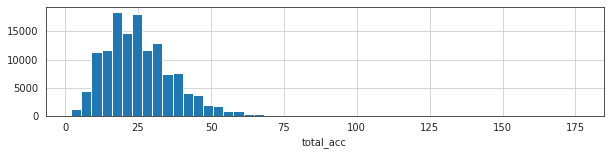

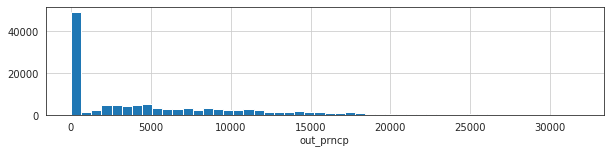

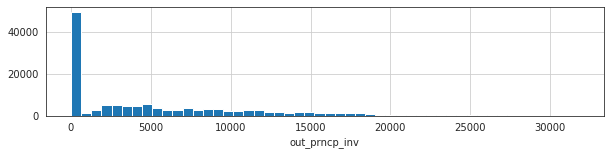

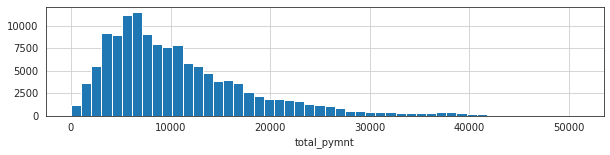

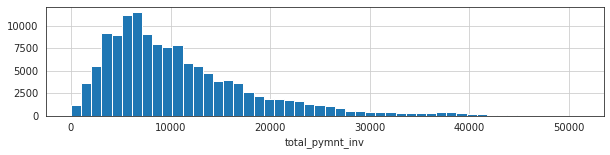

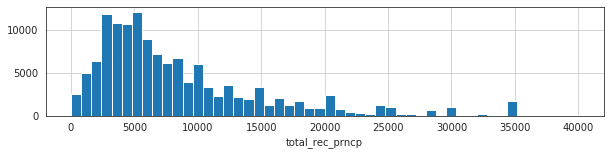

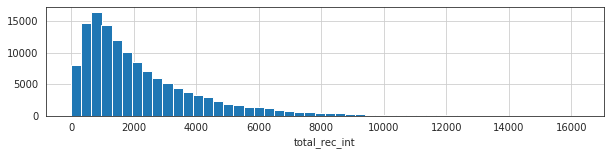

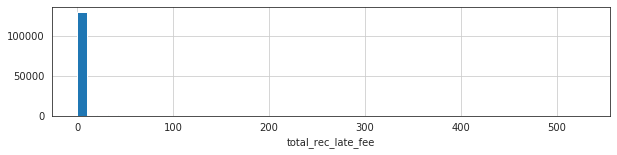

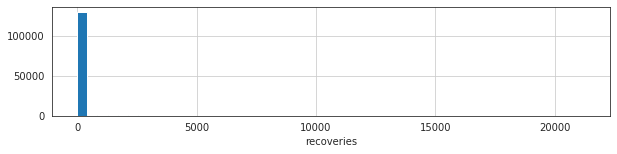

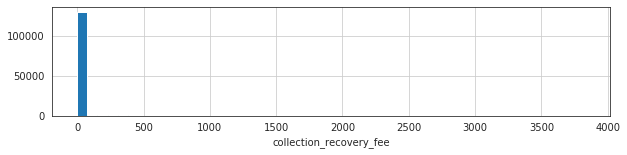

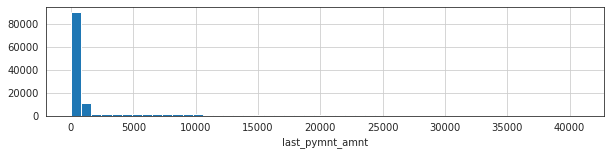

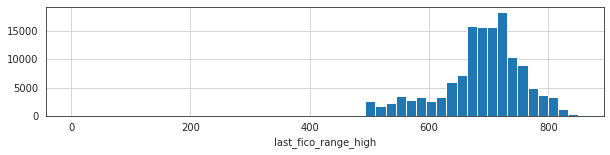

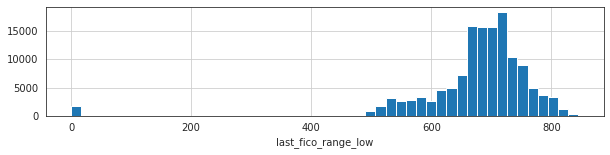

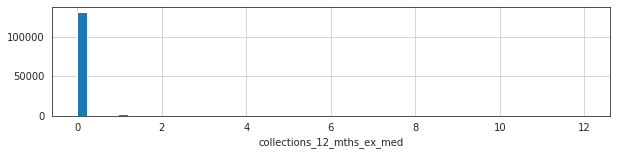

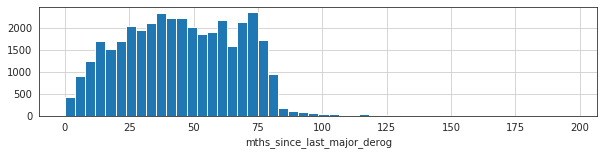

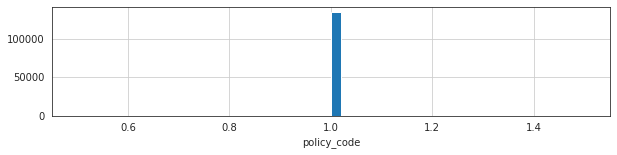

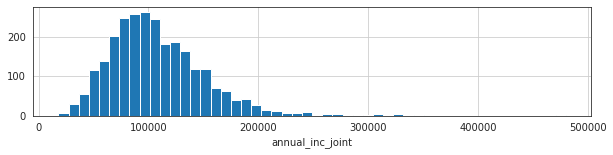

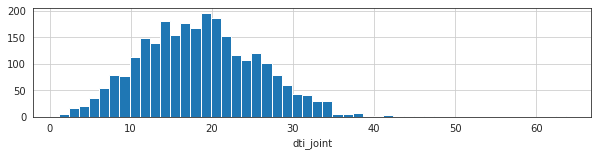

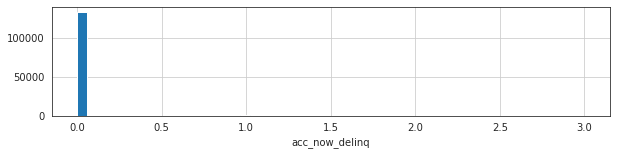

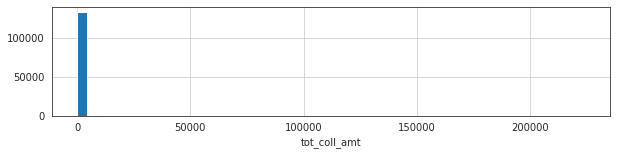

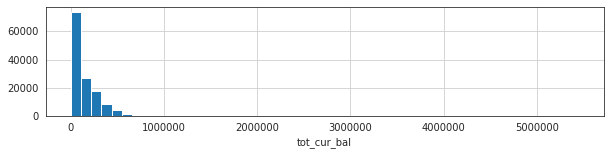

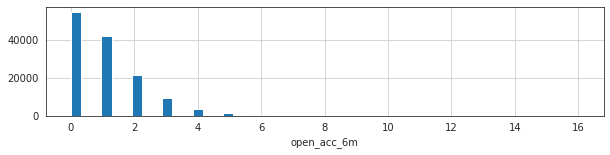

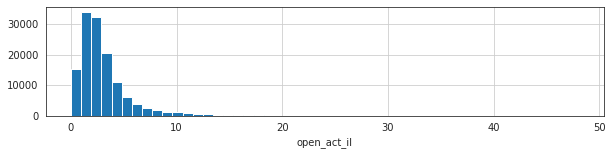

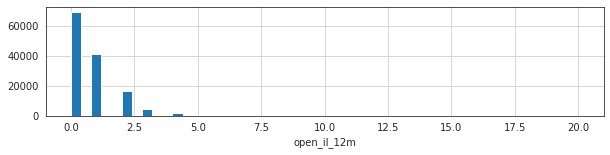

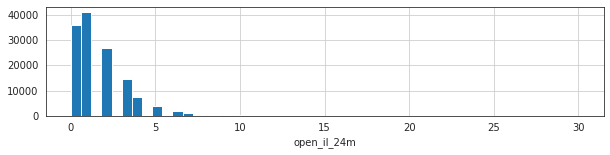

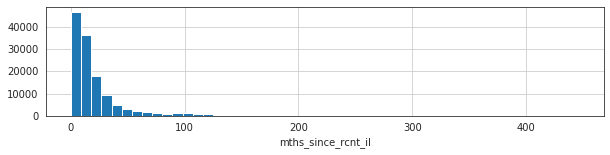

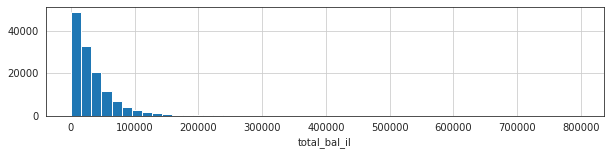

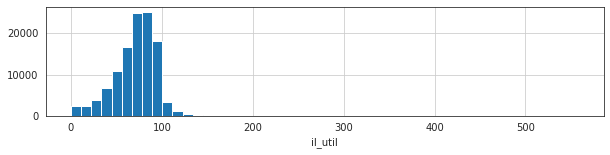

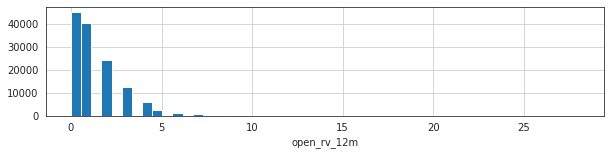

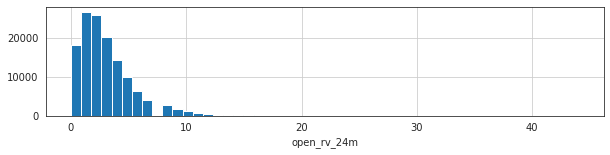

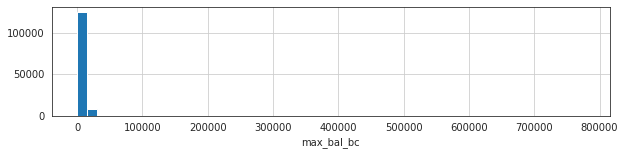

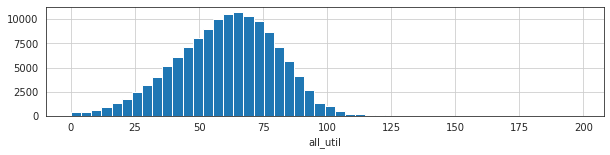

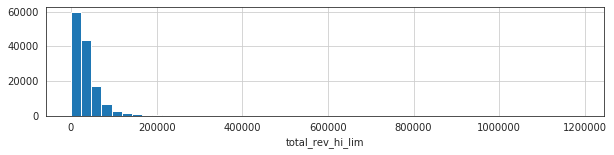

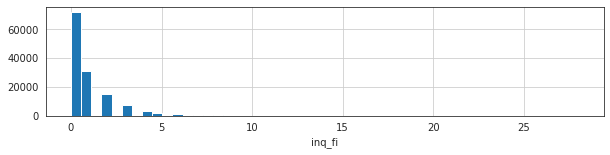

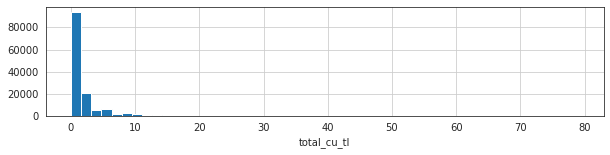

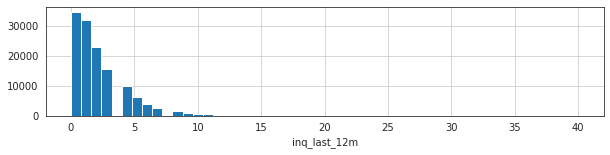

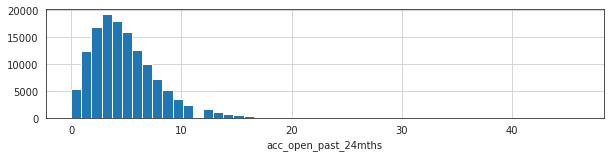

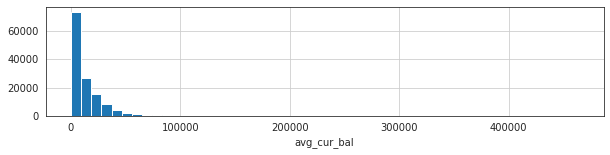

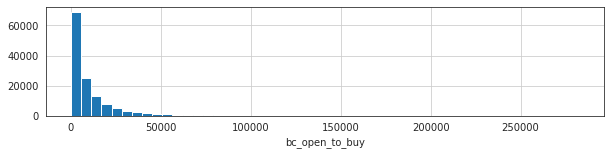

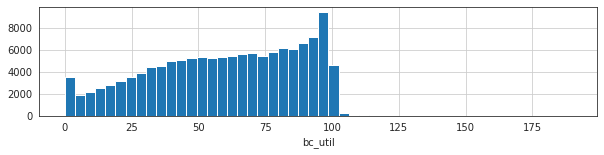

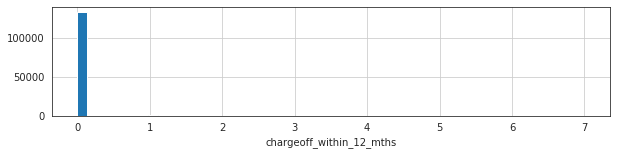

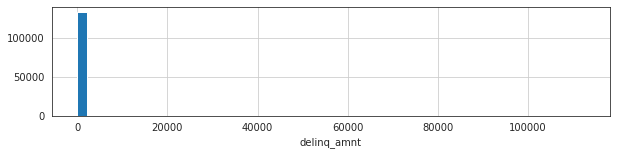

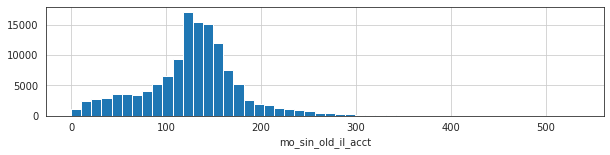

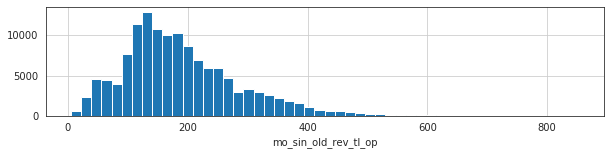

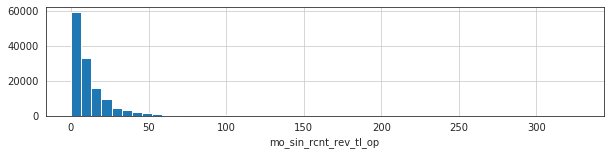

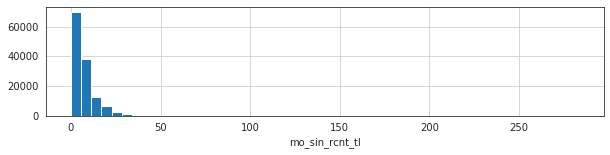

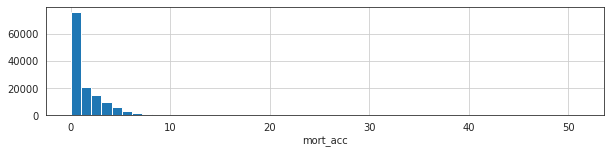

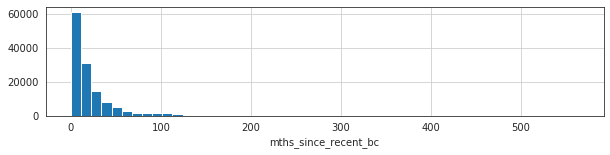

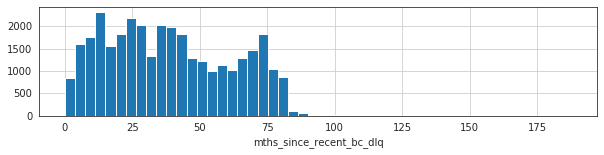

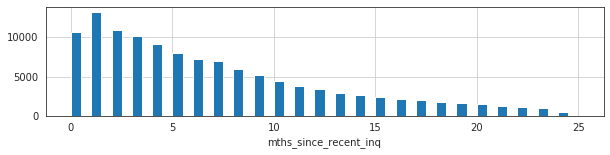

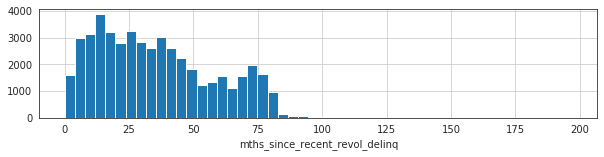

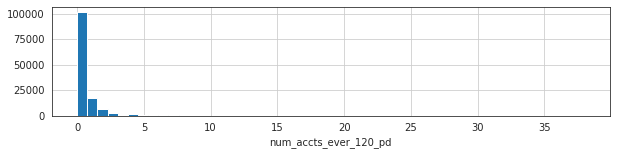

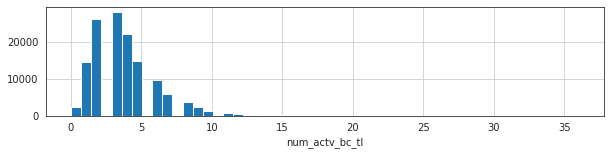

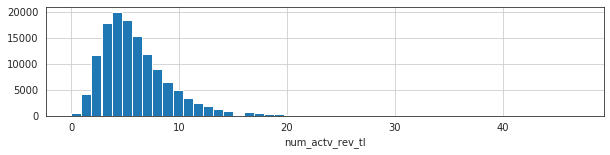

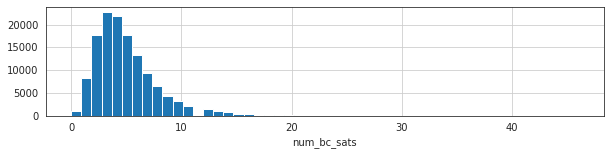

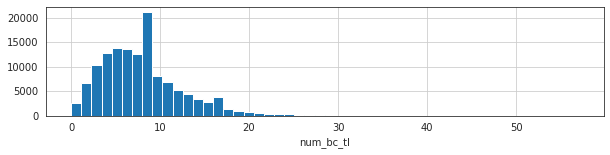

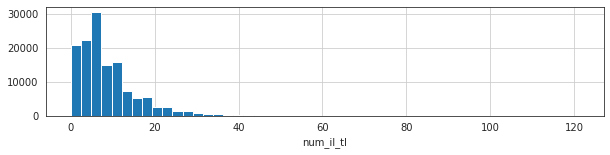

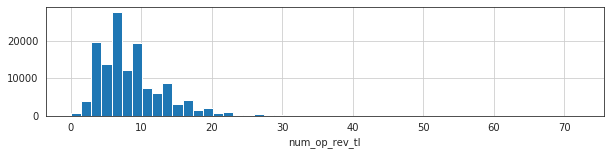

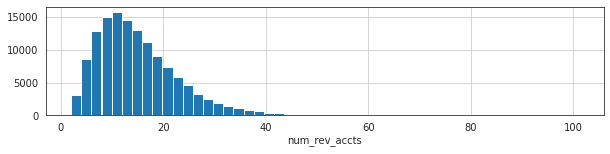

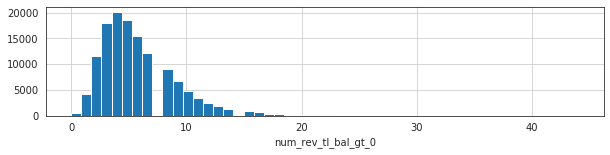

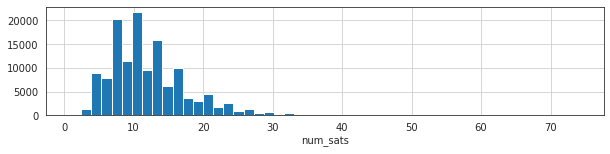

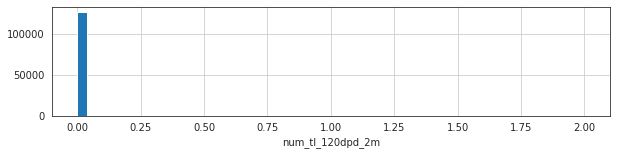

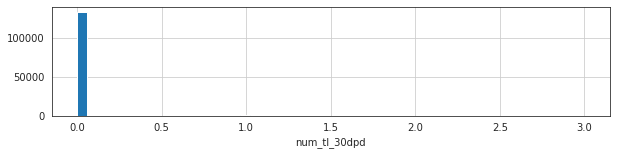

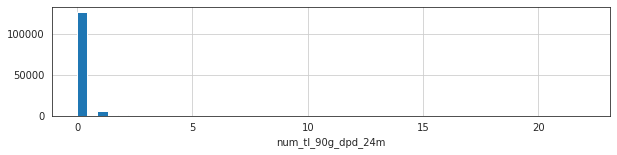

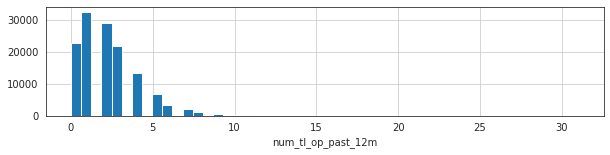

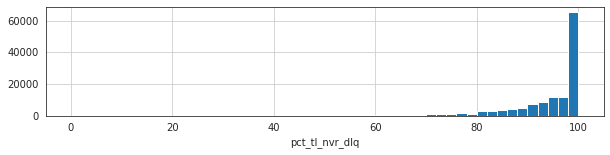

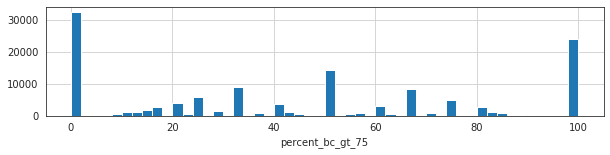

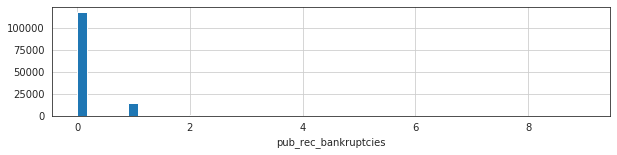

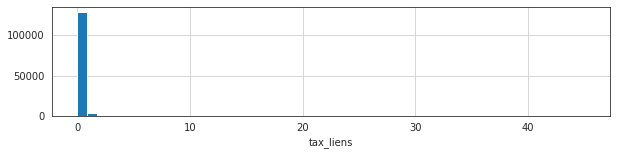

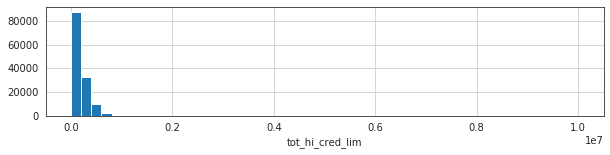

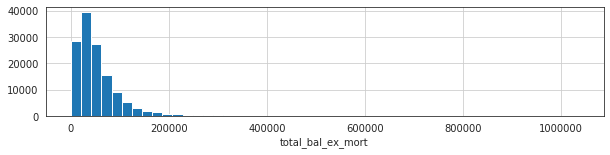

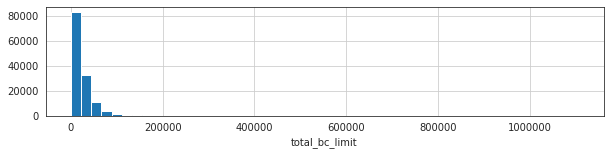

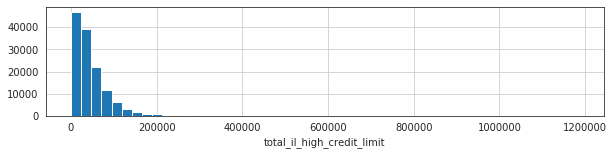

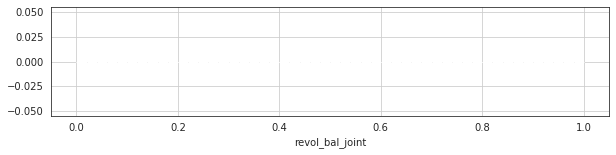

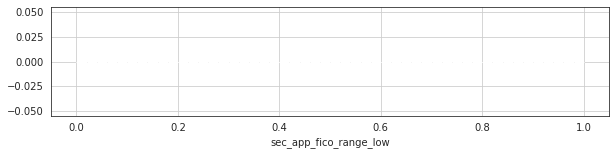

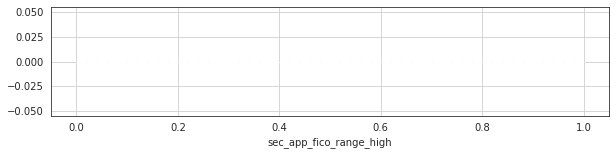

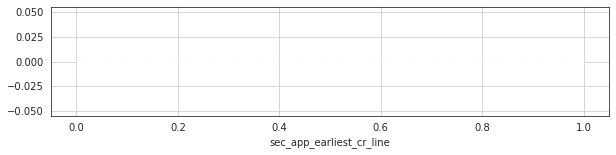

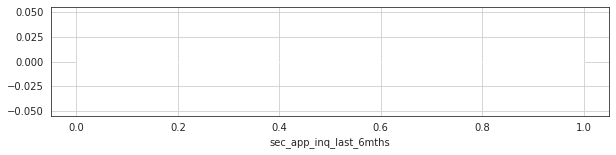

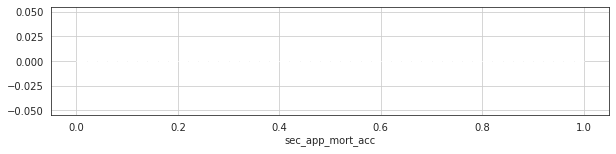

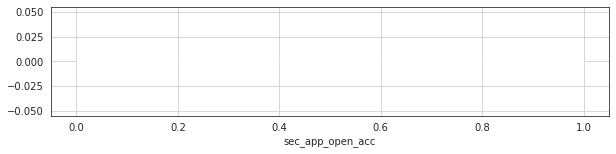

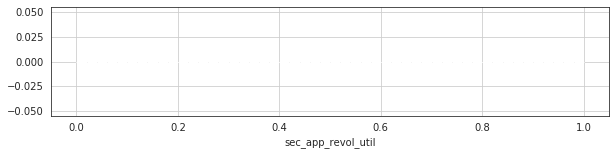

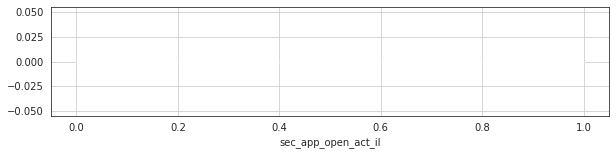

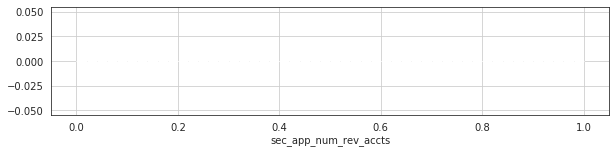

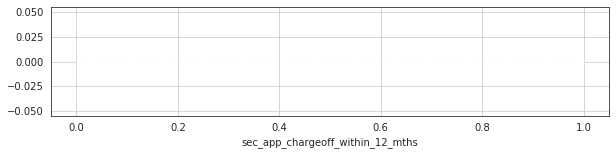

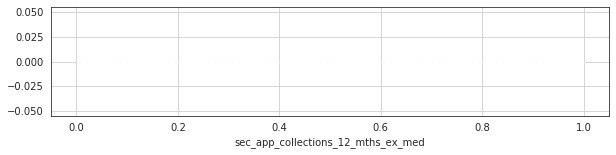

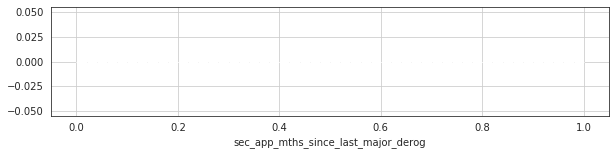

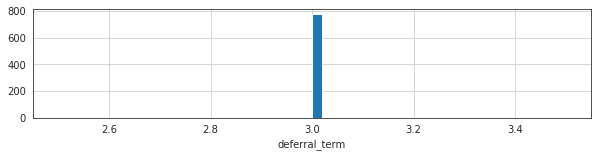

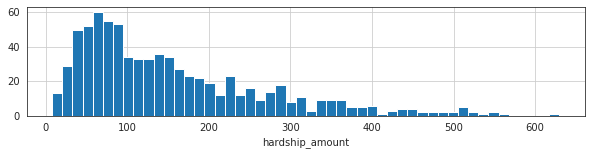

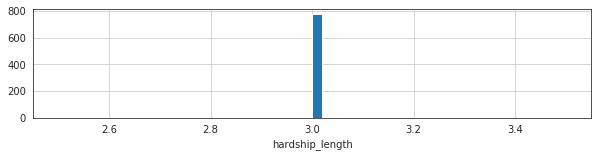

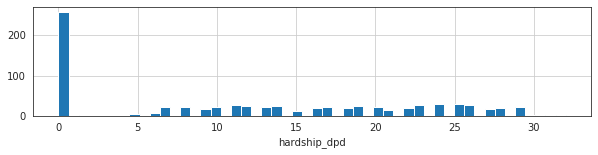

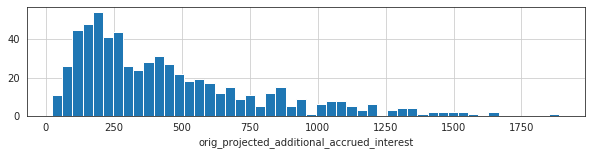

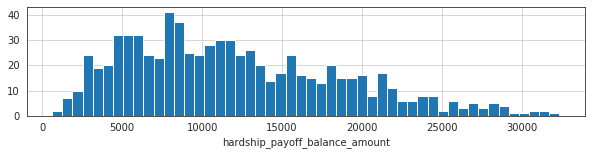

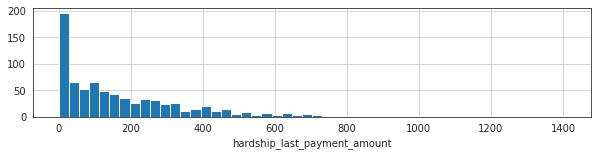

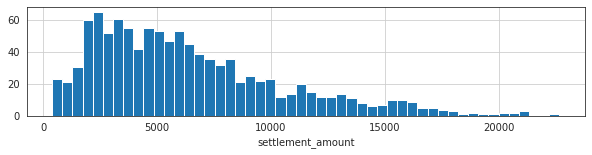

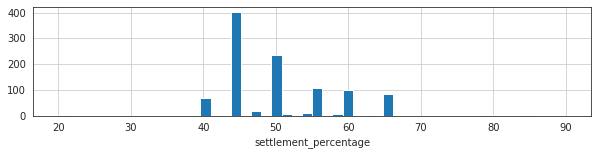

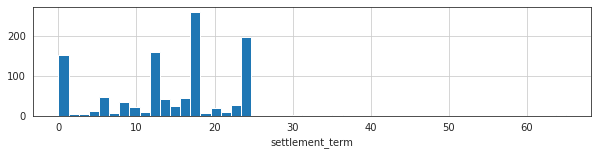

In [16]:
# Here we plot distribution charts for all the numerical columns in our dataframe
plot_histograms(loan_df_orig)

## Data Visualization Examples
### The Growth of Lending Club

In [49]:
# Build a statistics data frame based on issue date
# aggregate on loan amount
vis_df = loan_df_orig.copy().sample(5000)

### Outcome Variable: Loan Status
On the left is the breakdown of all loan status classifications.  On the right is our simple default classification based on our data prep

In [50]:
# Example of a groupby and aggregate 
df=vis_df[['loan_status', 'loan_amnt', 'funded_amnt']].groupby(['loan_status']).agg(['sum', 'count'])
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df=df.reset_index()
df

,loan_status,loan_amnt_sum,loan_amnt_count,funded_amnt_sum,funded_amnt_count
0,Charged Off,8987475.0,522,8987475.0,522
1,Current,47161300.0,3005,47161300.0,3005
2,Fully Paid,19051700.0,1295,19051700.0,1295
3,In Grace Period,1186225.0,66,1186225.0,66
4,Late (16-30 days),175925.0,10,175925.0,10
5,Late (31-120 days),1570450.0,102,1570450.0,102


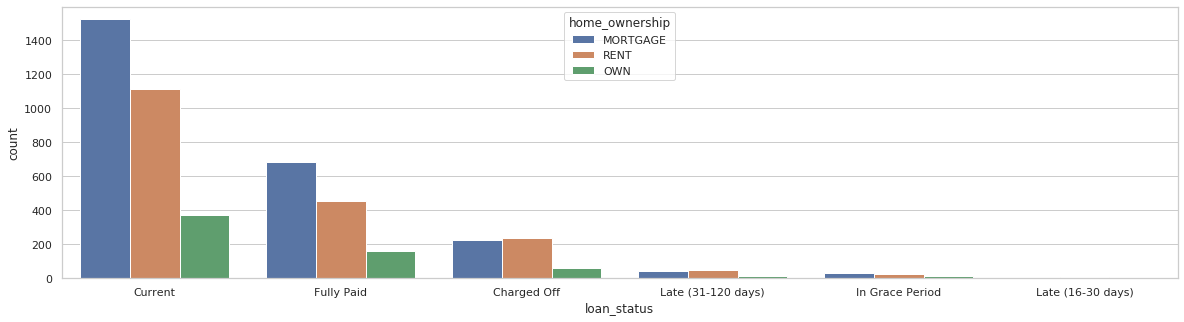

In [51]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")

#tips = sns.load_dataset("tips")
#ax = sns.barplot(x="loan_status", y="loan_amnt_count", data=df)
#ax = sns.barplot(x="loan_status", y="loan_amnt", data=vis_df)
ax = sns.countplot(x="loan_status", hue="home_ownership", data=vis_df)


### Borrowing by State 
Most of the money in terms of absolute borrowing is borrowed by people from California. For average loan amount per state, Alaska ranks on top.

In [52]:
# Create an aggregated dataframe ...
df=vis_df[['addr_state', 'loan_amnt', ]].groupby(['addr_state']).agg(['mean', 'sum'])
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df=df.reset_index()
df


,addr_state,loan_amnt_mean,loan_amnt_sum
0,AK,19851.562500,317625.0
1,AL,13629.326923,708725.0
2,AR,15384.677419,476925.0
3,AZ,15668.503937,1989900.0
4,CA,15681.157817,10631825.0
5,CO,15657.920792,1581450.0
6,CT,15535.937500,1242875.0
7,DC,17827.500000,178275.0
8,DE,11601.562500,185625.0
9,FL,14301.977401,5062900.0


In [ ]:
#Plotly Choropleth Example 
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df['addr_state'], # Spatial coordinates
    z = df['loan_amnt_mean'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "USD",
))

fig.update_layout(
    title_text = '2016 Lending Club Avg Loans by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()    

###  Loan Purpose Wordcloud
Lets try to get a sense of why people are borrowing ...

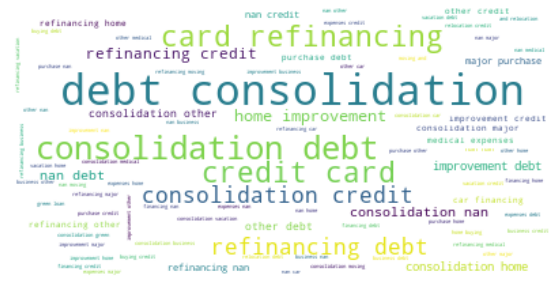

In [54]:
text = " ".join(str(purpose).lower() for purpose in loan_df_orig['title'])

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(background_color="white").generate(text)
# Display the generated image:
plt.figure(figsize=(20,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


As you can see, this could go on forever, but hopefully you get a sense of the power of data visualization

### Modelling Phase

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/modeling.png" width="800" height="500" align="middle"/>

### Train / Test set creation

One of the key points in any machine learning workflow is the **partitioning** of the data set into **train** and **test** sets.  The key idea here is that a model is built using the training data, and evaluated using the test data.  

There are more nuances to how you partition data into train/test sets, but for purposes of this lab we will omit these finer points.

In [62]:
%load_ext autoreload
%autoreload 2
from lc_utils_2020 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Instantiate lendingclub_ml object that will hold our test, and contain methods used for testing.
# Implementation done like this to ease the burden on users for keeping track of train/test sets for different
# models we are going to build.

my_analysis = lendingclub_ml(loan_df)

In [19]:
# Create a train / test split of your data set.  Paramter is test set size percentage 
# Returns data in the form of dataframes

my_analysis.create_train_test(test_size=0.33)

**create_train_test** : Dropping 2 timestamp columns issue_d and earliest_cr_line
**create_train_test** : Training set size: (89704, 225)
**create_train_test** : Testing set size: (44183, 225)
**create_train_test** : Train set loan_default:loan_paid ratio : 11277/78427
**create_train_test** : Test  set loan_default:loan_paid ratio : 5392/38791


## Dimension Reduction
For this modeling exercise we will perform a couple of tasks, **dimension reduction** and **classification** as shown in the following diagram.

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-workflow.png" width="800" height="500" align="middle"/>

**Dimension Reduction** is useful in scenarios when you have a large number of columns and you would like to reduce that down to a compressed representation .  In this lab we will try 2 methods of dimension reduction.  It will be your choice to decide which method you want to use for the classification part of the lab ! (you could even decice to bypass this if you want ...)


### Dimension Reduction - PCA

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-pca.png"  width="200" height="125" align="middle"/>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.

A simple way to think about PCA is that it helps compress the data in a lossy representation of the original dataset.

This will also be used to help us visualize the data as you will see below

**build_pca_model** : Explained Variance : [0.05273159 0.03915729 0.03200515 0.02697703 0.02205358 0.01884257
 0.01650913 0.01549409 0.01424003 0.0126312  0.01219791 0.01116194
 0.01107317 0.01067109 0.00986656 0.00976973 0.00951809 0.00938076
 0.00929004 0.00911505 0.00905296 0.00899589 0.00892721 0.00878349
 0.00876695 0.00870437 0.00866278 0.00846316 0.00834286 0.00792983]


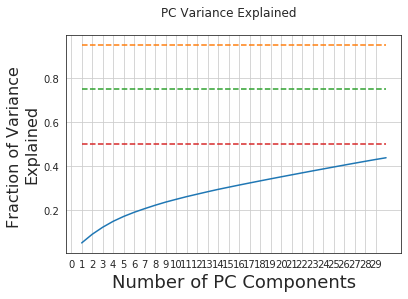

In [20]:
# Dimension Reduction using PCA
# PCA model saved in data structure ..
my_analysis.build_pca_model(n_components=30)

In the chart above, you can see that we get ok results from PCA.  Using the first 20 principal components, we can account for ~50% of the variance described in the dataset.  **Feel free to change the number of principal components above to see if adding more helps with explained variance.**

### Now update our test dataframe with new columns that are predicted by our PCA.  

Here we will now take the models that we built and pass our test data set through the models.   By doing this, we will have reduced the number features in our data set by a significant amount (~177 colums => ~5-20 columns!)  .  

In this step we will add new columns to our test/train data frames for  our PCA model .  Don't worry about the details of this step, its just required for some followon visualization, and training steps ahead. 



In [55]:
my_analysis.add_pca_columns_to_df()

**update_df** : Starting update for train dataframe 
**update_df** : Adding PCA columns first
**update_df** : Creating new columns : {0: 'PC0', 1: 'PC1', 2: 'PC2', 3: 'PC3', 4: 'PC4', 5: 'PC5', 6: 'PC6', 7: 'PC7', 8: 'PC8', 9: 'PC9', 10: 'PC10', 11: 'PC11', 12: 'PC12', 13: 'PC13', 14: 'PC14', 15: 'PC15', 16: 'PC16', 17: 'PC17', 18: 'PC18', 19: 'PC19', 20: 'PC20', 21: 'PC21', 22: 'PC22', 23: 'PC23', 24: 'PC24', 25: 'PC25', 26: 'PC26', 27: 'PC27', 28: 'PC28', 29: 'PC29'}
**update_df** : Updating train Dataframe 
**update_df** : Starting update for test dataframe 
**update_df** : Adding PCA columns first
**update_df** : Creating new columns : {0: 'PC0', 1: 'PC1', 2: 'PC2', 3: 'PC3', 4: 'PC4', 5: 'PC5', 6: 'PC6', 7: 'PC7', 8: 'PC8', 9: 'PC9', 10: 'PC10', 11: 'PC11', 12: 'PC12', 13: 'PC13', 14: 'PC14', 15: 'PC15', 16: 'PC16', 17: 'PC17', 18: 'PC18', 19: 'PC19', 20: 'PC20', 21: 'PC21', 22: 'PC22', 23: 'PC23', 24: 'PC24', 25: 'PC25', 26: 'PC26', 27: 'PC27', 28: 'PC28', 29: 'PC29'}
**update_df

In [22]:
#[x for x in my_analysis.train_df.columns if 'PC' in str(x)]
#for c in my_analysis.train_df.columns: 
#    print(c)
#display(my_analysis.X_train_scaled.head(10))
#my_analysis.train_df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_bin,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Business,Car financing,Credit Card Consolidation,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation,unknown,f,w,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Dec-2017,Jan-2018,Nov-2017,unknown,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2015,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Individual,Joint App,N,Y,Cash,DirectPay,N,Y
0,-0.067842,-0.067842,-0.067020,0.080250,-0.218616,-0.510642,-0.378782,0.132607,0.132597,2.755972,2.346902,0.325764,-0.360131,-0.518457,0.135686,0.234007,0.234470,-0.218921,-0.127836,-0.151192,-0.151686,-0.440872,0.388602,0.327318,-0.128871,0.0,-0.080759,-0.118149,-0.751350,-0.033552,-0.603914,-0.754447,-0.970405,0.159590,-0.378451,-0.033030,-0.243000,1.556225,-0.779061,-0.784902,-0.264452,-0.633031,-0.197530,0.331775,0.669041,-0.728529,-0.331581,-0.657903,-0.086292,-0.024262,-0.729570,-0.546783,-0.484960,-0.316693,-0.346934,-0.593656,-0.685209,1.860515,0.912596,1.141099,0.635949,1.457899,-0.628007,0.923434,0.880000,1.203097,0.337318,-0.03113,-0.065752,-0.179867,-0.646893,-0.594282,-0.444847,-0.338844,-0.155716,-0.683727,-0.587826,-0.601126,-0.378809,-0.174397,-1.353048,-0.728887,0.626315,-0.626315,-0.497651,1.518018,-0.612635,-0.373347,-0.276033,-0.163228,-0.083289,-0.253712,-0.179564,-0.17277,-0.182845,-0.218205,-0.238240,-0.249378,3.804850,-0.260902,-0.257153,-0.266200,-0.244115,-0.242315,-0.235221,-0.210928,-0.188658,-0.16409,-0.14623,-0.152547,-0.135658,-0.135913,-0.129654,-0.121265,-0.107987,-0.101066,-0.091265,-0.080038,-0.064965,-0.06058,-0.058983,-0.045089,-0.041199,-0.035515,-0.032215,-0.029501,-0.998463,2.701242,-0.783279,1.359485,-0.778673,-0.610381,0.042271,-0.042271,-0.101515,-0.562467,-1.155978,3.767803,-0.062676,-0.149419,-0.104663,-0.075542,-0.236879,-0.024314,-0.101122,-0.074943,-0.097458,-0.098502,0.0,-0.528326,-1.052124,-0.023378,-0.061041,3.908992,-0.144471,-0.101851,-0.073039,-0.231636,-0.071085,-0.294340,-0.429726,0.429726,-0.10526,-0.144229,-0.133425,-0.156592,-0.140974,-0.063033,-0.137311,-0.030063,-0.148481,-0.12637,-0.150391,-0.116393,-0.151511,-0.088172,-0.166085,-0.106979,-0.1485

,index,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,emp_bin,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Business,Car financing,Credit Card Consolidation,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation,unknown,f,w,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Dec-2017,Jan-2018,Nov-2017,unknown,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2015,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Individual,Joint App,N,Y,Cash,DirectPay,N,Y,id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
0,63389,15000.0,15000.0,15000.0,482.25,62000.0,14.61,0.0,700.0,704.0,3.0,71.00000,14.0,0.0,5056.0,27.0,7208.09,7208.09,1844.97,0.0,0.0,0.0,482.25,714.0,710.0,0.0,1.0,0.0,0.0,24796.0,1.0,1.0,0.0,0.0,26.0,19740.0,70.0,1.0,7.0,1199.0,45.0,26500.0,0.0,1.0,3.0,7.0,1907.0,5624.0,41.4,0.0,0.0,90.0,135.0,5.0,5.0,1.0,5.0,3.000000,3.0,6.0,10.0,7.0,15.0,4.0,13.0,22.0,10.0,14.0,0.0,0.0,0.0,1.0,88.9,28.6,0.0,0.0,54918.0,24796.0,9600.0,28418.0,0,5.0,19.1,4138,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,72714966,0.672926,-0.574958,2.929456,-3.232135,0.437404,-0.677805,-0.079265,2.106327,1.005519,0.354334,-0.826981,-0.358506,1.402321,-1.596542,0.081123,1.998943,0.264758,0.096730,-1.844366,2.903151,-2.422780,-0.362761,0.114736,-2.112855,0.321210,-0.586134,0.205111,-1.288077,-0.592085,0.768029
1,104117,24750.0,24750.0,24750.0,758.46,65000.0,32.17,0.0,765.0,769.0,0.0,33.80781,9.0,0.0,8886.0,41.0,10199.51,10199.51,2126.71,0.0,0.0,0.0,758.46,774.0,770.0,0.0,1.0,0.0,0.0,170549.0,0.0,3.0,1.0,3.0,7.0,161663.0,64.0,0.0,0.0,6229.0,60.0,17200.0,0.0,0.0,0.0,3.0,21319.0,8314.0,51.7,0.0,0.0,137.0,200.0,47.0,7.0,0.0,47.0,6.812589,0.0,4.0,4.0,5.0,5.0,27.0,6.0,14.0,4.0,9.0,0.0,0.0,0.0,1.0,100.0,20.0,0.0,0.0,190227.0,170549.0,17200.0,173027.0,0,10.0,51.7,6089,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,

### Cool Visualizations using our dimension reduction columns

Next we will plot a few scatterplot grids based on our pricipal component and autoencoder representations of the data

We will color each data point using this key
```
Green -> Fully paid or current loan
Red   -> Loan in default
```

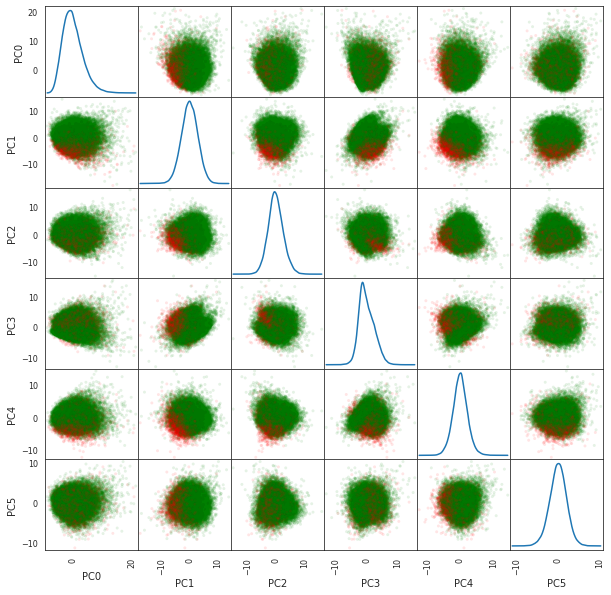

In [23]:
# This will take a minute or so ...
my_analysis.visualize_dimred_results(mode='pca')

In [60]:
# Example : Filter based on Principal Components ..
a = my_analysis.test_df
f_df = a[(a['PC0'] < 1) & (a['PC1'] <0)]
display(f_df.describe())
display(loan_df.describe())

,level_0,index,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,emp_bin,revol_util_1,time_history,36 months,60 months,A,B,C,D,E,F,G,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,n,y,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Business,Car financing,Credit Card Consolidation,Credit card refinancing,Debt consolidation,Green loan,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation,unknown,f,w,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Dec-2017,Jan-2018,Nov-2017,unknown,Apr-2016,Apr-2017,Aug-2016,Aug-2017,Dec-2015,Dec-2016,Feb-2016,Feb-2017,Jan-2016,Jan-2017,Jul-2016,Jul-2017,Jun-2016,Jun-2017,Mar-2016,Mar-2017,May-2016,May-2017,Nov-2016,Nov-2017,Oct-2016,Oct-2017,Sep-2016,Sep-2017,unknown,Individual,Joint App,N,Y,Cash,DirectPay,N,Y,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
count,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,1.484400e+04,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.0,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.00000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,1.484400e+04,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.00000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,14844.000000,148

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,default
count,0.0,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133870.000000,133887.000000,133887.000000,133887.000000,133886.000000,69322.000000,23671.000000,133887.000000,133887.000000,1.338870e+05,133887.000000,133887.000000,133887.000000,133887.000000,1.338870e+05,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,38074.000000,133887.0,2661.000000,2659.000000,133887.000000,133887.000000,1.338870e+05,133825.000000,133826.000000,133826.000000,133826.000000,130186.000000,133826.000000,116008.000000,133826.000000,133826.000000,133826.000000,133820.000000,1.338870e+05,133826.000000,133825.000000,133825.000000,133887.000000,133887.000000,132776.000000,132712.000000,133887.000000,133887.000000,130241.000000,133887.000000,133887.000000,133887.000000,133887.000000,132843.000000,33756.000000,120089.000000,47783.000000,133887.000000,133887.000000,133887.000000,133887.000000,133887.00000,133887.000000,133887.000000,133887.000000,133887.000000,133887.000000,126266.000000,133887.000000,133887.000000,133887.000000,133887.000000,132758.000000,133887.000000,133887.000000,1.338870e+05,1.338870e+05,1.338870e+05,1.338870e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,774.0,774.000000,774.0,774.000000,635.000000,774.000000,774.000000,1087.000000,1087.000000,1087.000000,133889.000000
mean,NaN,15589.394041,15589.394041,15581.984023,460.863923,8.046397e+04,19.547033,0.343476,695.750633,699.750827,0.576498,33.807810,66.361413,12.119922,0.238709,1.861627e+04,25.343245,5695.480540,5692.970475,2292.920647,1.102888e+00,74.221479,13.246068,3186.572260,687.161039,676.487710,0.021257,45.218154,1.0,108617.690135,18.603103,0.006969,259.246596,1.472398e+05,1.045373,2.797147,0.747157,1.625215,21.641175,35704.147819,70.741044,1.373769,2.930006,6183.582271,60.654499,3.636171e+04,0.952924,1.544121,2.187215,4.799159,13509.653738,10857.383932,59.762205,0.010120,21.343491,127.552652,188.682553,13.155243,7.799757,1.671402,23.845607,38.836799,6.812589,35.217672,0.518908,3.809533,5.917796,4.955836,8.00537,8.703407,8.561324,14.702585,5.857858,12.062478,0.000966,0.004765,0.090614,2.248732,94.061616,44.55

If you can discern a pattern between the red / green dots, its likely we can use a classifier to automatically seperate them! We'll see that in a few more sections

## Lending Club Default Prediction using Random Forest

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-modeling-traintest.png"  width="600" height="375" align="middle"/>

Here we will build a classifier to predict if loan will fail or not.  We will us a 
** Random Forest ** tree algorithm  .  You will have 2 options for data sources, 
* the raw data
* PCA dimension reduction features

To evaluate our model, we will use a simple contingency table (showing true/false positve/negative).  However, this is a fairly simplistic method.  Better method that data scientists use are F1 score, and PR/ROC curves but thats beyond the scope of this lab.

Step 1 here is to set our baseline result.  In this example, we are dealing with a **skewed** dataset.  This means, on average, most people will not default, and they pay their loan off.  If you built a classifier that just predicted no default, you would be right most of the time.  Lets see the stats from our dataset below....

In [24]:
# Set our baseline
my_analysis.train_df['default'].describe()

count    89704.000000
mean         0.125713
std          0.331528
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

As you can see, **only ~12.8% of the applicants default**.  Any classifier we build must be better than this, or we aren't doing a very good job ;)

In [29]:
# modes
# pca           : principal components only
# raw           : all the data non reduced
# raw_no_grades : all the data non reduced except the grade info provided by lending club

mode = 'raw' # ae , raw, raw_no_grades
x_cols =[]
if(mode == 'pca') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' in x]
elif(mode == 'raw') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' not in x]
            x_cols.remove('default')
elif(mode == 'raw_no_grades') :
            x_cols = [x for x in my_analysis.train_df.columns if 'PC' not in x]
            import re
            x_cols = [x for x in x_cols if not re.match('^[ABCDEFG]',x)]
            x_cols.remove('default')

#print(x_cols)


['index', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_

### Random Forest Example

In [30]:
# Build a dataframe with selected columns ...
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = my_analysis.train_df[x_cols]
y = my_analysis.Y_train

In [31]:
## Simple Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(max_depth=5,n_estimators=300, random_state=0)

clf.fit(X,y)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Confusion Matrix

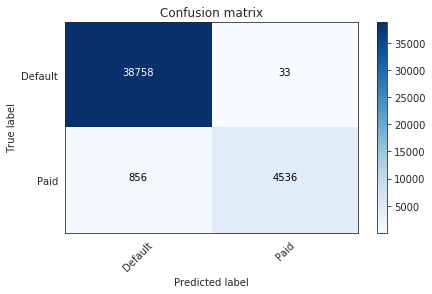

In [32]:
Y_test_predict = np.where(clf.predict(my_analysis.test_df[x_cols]) > 0.5, 1, 0 )

cnf_matrix =confusion_matrix(my_analysis.Y_test, Y_test_predict)
class_names =  ['Default','Paid']
plot_confusion_matrix(cnf_matrix, class_names)

### Explainability : RF Feature Importance

In [33]:
# Random Forest Explainability
#print(len(clf.feature_importances_))
#print(len(X.columns))
rf_feature_importance = dict(zip(X.columns,clf.feature_importances_))


sort_rf_feature_importance = sorted(rf_feature_importance.items(), key=lambda x: x[1], reverse=True)

for i in sort_rf_feature_importance:
    print(i[0], i[1])

last_fico_range_low 0.1603399211710119
last_fico_range_high 0.1437350367254732
last_pymnt_amnt 0.08288560298999591
collection_recovery_fee 0.07642528001790322
recoveries 0.07445315257563169
out_prncp 0.026135654433055922
out_prncp_inv 0.019293547525115175
Dec-2017 0.014802720999050768
N 0.010929536871565388
total_rec_late_fee 0.005433524758877392
Y 0.004172425677844359
A 0.003462821758422586
Feb-2017 0.0032224099655267227
Nov-2017 0.0030975816699359204
 60 months 0.0021099510827911703
n 0.0019065298416625898
fico_range_low 0.0018081116618675448
E 0.001773954561134124
y 0.0017484176680806034
fico_range_high 0.0014896647763741945
F 0.001445109650358621
dti 0.0009857639969921245
 36 months 0.0009732758785704406
B 0.0008689732988178535
Jun-2017 0.0008583607006260929
total_rec_int 0.0008098484162356504
avg_cur_bal 0.0007455971204206448
mort_acc 0.0007446871990640158
D 0.0007334860931984668
bc_open_to_buy 0.0006692012793428436
funded_amnt_inv 0.0004980867610295717
A1 0.0004004139895255794
to

### Credits 
* Bob Chesebrough - IBM AICoC Data Scientist
* Catherine Cao - IBM FSS Data Scientist
* Dustin VanStee - IBM AICoC Data Scientist

* [Hands on Machine Learning - Geron] (https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)
